In [9]:
import networkit as nk
import networkx as nx
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
import ndlib.models.CompositeModel as gc
import ndlib.models.compartments as nc

from bokeh.io import output_notebook, show
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence

#NK and GT don't have methods to read adjacency lists.

#Size of graph is currently: 1.2m nodes, 8.7m edges
#Method 1 - Import GML into NK, then create NX graph (29s)
#gmlReader = nk.graphio.GMLGraphReader()
#G = gmlReader.read("dataset.gml")
#print(G.numberOfNodes())
#print(G.numberOfEdges())

#graph = nx.Graph()

#print("Adding nodes...")
#for i in G.iterNodes():
#    graph.add_node(i)

#print("Adding edges...")
#for i in G.iterEdges():
#    graph.add_edge(i[0],i[1])

#del(G)
#print(len(graph.nodes()))
#print(len(graph.edges()))

#Method 2 - Read adjacency list into NX (37s)
#G = nx.read_adjlist('dataset.adjlist')
#print(len(G.nodes()))
#print(len(G.edges()))

#Method 3 - Read GML into GT (1m)
#graph = gt.load_graph("dataset.gml")
#print(len(graph.get_vertices()))
#print(len(graph.get_edges()))

#Method 4 - Read GML into NX (8.30m)
#G = nx.read_gml('dataset.gml', label='id')
#relabeled = nx.convert_node_labels_to_integers(G)
#del(G)
#print(len(relabeled.nodes()))
#print(len(relabeled.edges()))

#Method 5 - Read Pickle into NX ()
G = nx.read_gpickle('dataset')
relabeled = nx.convert_node_labels_to_integers(G)
del(G)
print(len(relabeled.nodes()))
print(len(relabeled.edges()))

FileNotFoundError: [Errno 2] No such file or directory: 'dataset'

In [3]:
#STANDARD SEIR MODEL SIMULATION
print("Simulating...")
# Model selection
model = ep.SEIRModel(relabeled)

# Model Configuration
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.57)
cfg.add_model_parameter('gamma', 0.15)
cfg.add_model_parameter('alpha', 0.2)
cfg.add_model_parameter("fraction_infected", 0.05)
model.set_initial_status(cfg)

# Simulation execution
iterations = model.iteration_bunch(10,progress_bar=True)
trends = model.build_trends(iterations)

Simulating...


100%|██████████| 60/60 [02:53<00:00,  2.90s/it]


In [ ]:
#CUSTOM SEIR_AS MODEL SIMULATION
print("Simulating...")

from ndlibCustom.SEIR_ASModel import SEIR_ASModel
# Model selection
model = SEIR_ASModel(relabeled)

# Model Configuration
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.57) #Infection rate from I_A/S Neighbors
cfg.add_model_parameter('gamma', 0.15) #Recovery/Removal rate
cfg.add_model_parameter('alpha', 0.2) #Latent period
cfg.add_model_parameter('kappa', 0.25) #Symptomatic/Asymptomatic Ratio

#This parameter "smoothens" out the infection rate in the first iterations.
cfg.add_model_parameter('tp_rate', 0) #Infection rate does not depend on neighbour sample size

cfg.add_model_parameter("fraction_infected", 0.05) #Starting infected nodes
model.set_initial_status(cfg)

# Simulation execution
iterations = model.iteration_bunch(60,progress_bar=True)
trends = model.build_trends(iterations)

Simulating...


  3%|▎         | 2/60 [00:06<02:04,  2.15s/it]

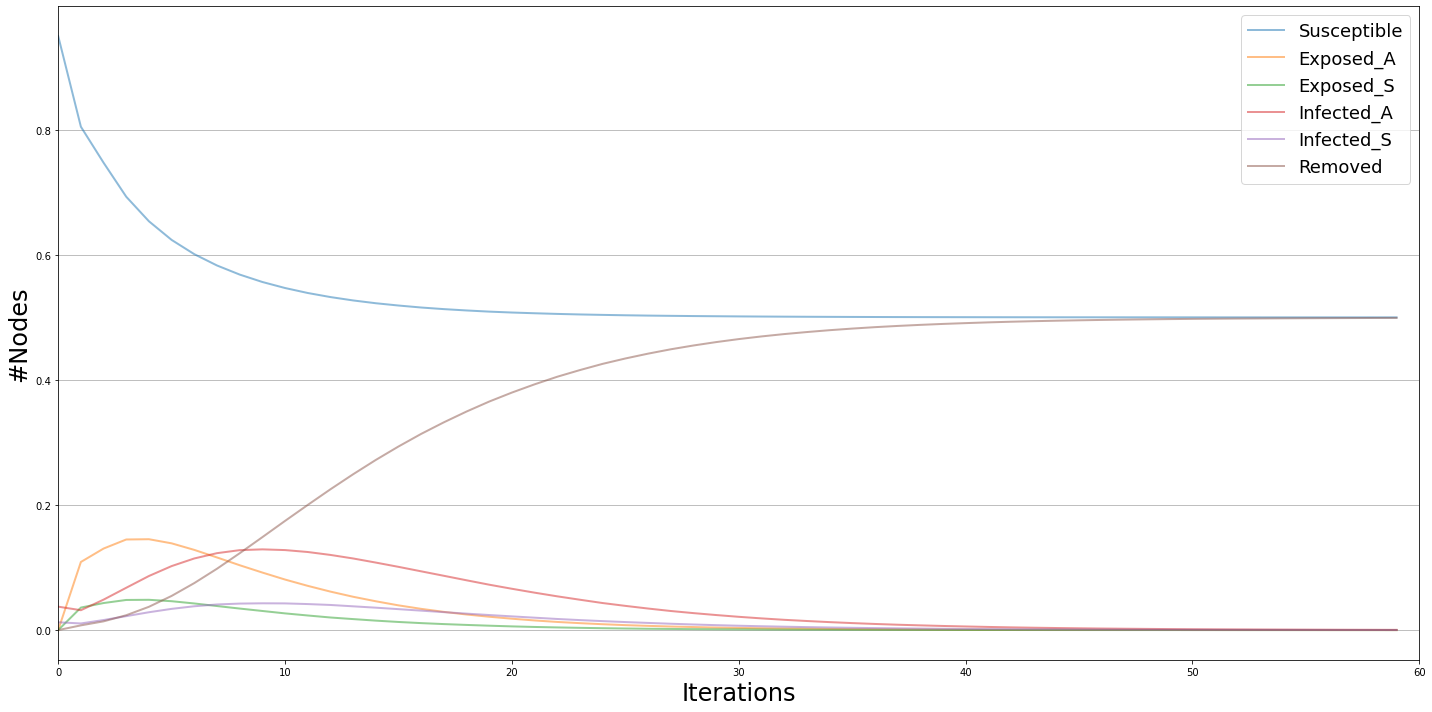

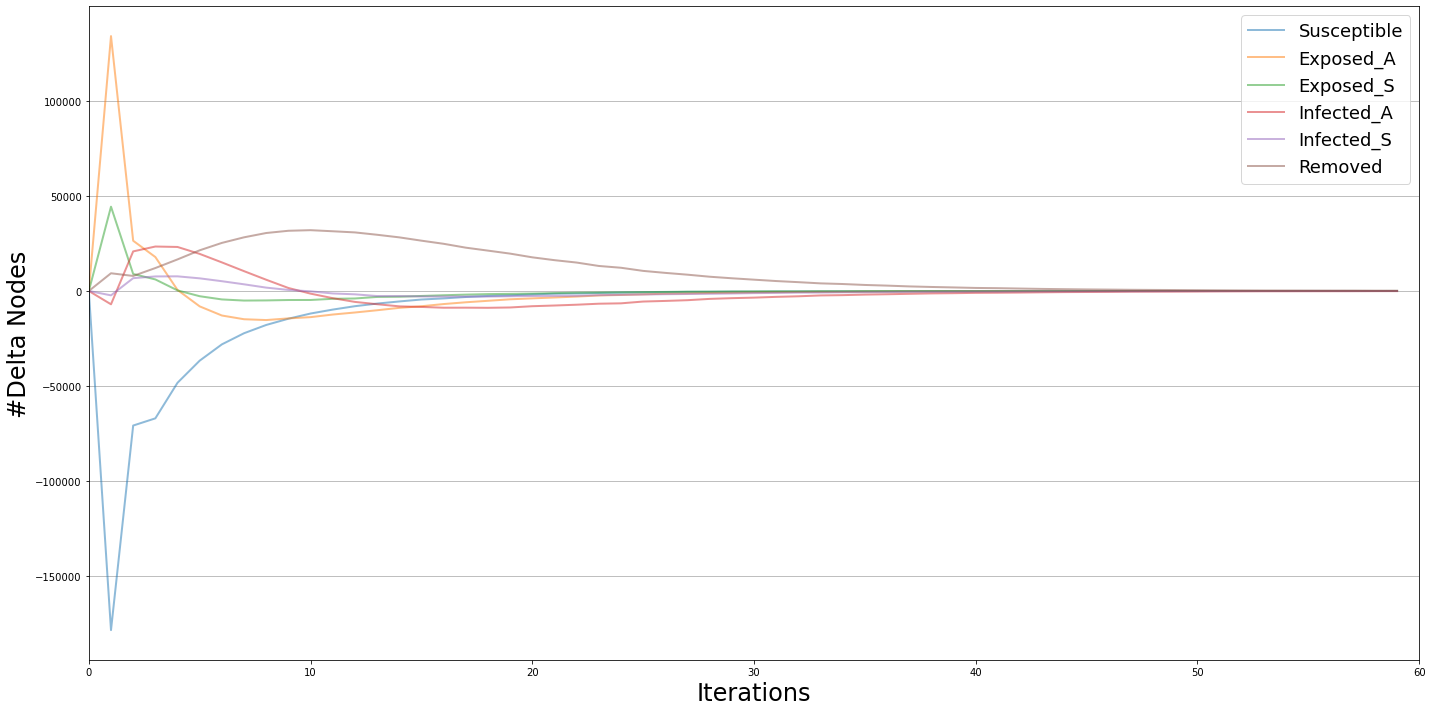

In [7]:
viz = DiffusionTrend(model, trends)
p = viz.plot()

viz2 = DiffusionPrevalence(model, trends)
p2 = viz2.plot()